# Exploring the Dataset

In [1]:
import cudf as xd
import numpy as np
import matplotlib.pyplot as plt
RAPIDS=True
%matplotlib inline

import panel as pn
pn.extension()

In [2]:
import os
os.getcwd()
os.chdir('/home/cdsw')

### Bureau Balance

Shows history of account for a particular SK_ID_BUREAU.
The Months Balance is time relative to application date the loan

The Status shows details on the Loan with C = Closed, X = unknown status, 
0 means nothing past due / 1 means something between 0-30 days past due / 2 means something between 31-60 days past due and 5 means something 120 days past due or written off


In [3]:
pandas_dtypes = {'MONTHS_BALANCE': np.int64, 'STATUS': 'category'}

if RAPIDS: 
    bb_dtypes = [] # rapids doesn't accept partial dtypes
else: 
    bb_dtypes = pandas_dtypes 

bureau_balance = xd.read_csv(filepath_or_buffer='data/bureau_balance.csv', 
                               #index_col = 'SK_ID_BUREAU',
                                dtype=bb_dtypes)

In [4]:
# check the columns and the dtypes
bureau_balance.dtypes

SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

In [5]:
# see if the SK_ID_BUREAU is unique
len(bureau_balance) == len(bureau_balance.SK_ID_BUREAU.unique())

False

In [6]:
# see the average months history per bureau id
history_count = bureau_balance[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()

len(history_count)

817395

In [7]:
type(history_count)

cudf.core.dataframe.DataFrame

Rapids can plot charts too though due to the render overhead, it is best for big dataframes over 1M rows and complex aggregations

In [8]:
# Normal Pandas Plot 
#plt.hist(history_count.MONTHS_BALANCE.to_arrow(), bins=100)

In [9]:
# RAPIDS cuxfilter plot
import cuxfilter

cux_df = cuxfilter.DataFrame.from_dataframe(history_count)
bar_chart_1 = cuxfilter.charts.bar('MONTHS_BALANCE')

dashboard = cux_df.dashboard(charts=[bar_chart_1])

bar_chart_1.view()

HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=800)

In [10]:
bureau_balance.STATUS.unique()
#bureau_balance[['SK_ID_BUREAU', 'STATUS']].unique()

0    C
1    0
2    X
3    1
4    2
5    3
6    5
7    4
Name: STATUS, dtype: object

In [11]:
# exploring what is in the records for one SK_ID_BUREAU number
bureau_balance[bureau_balance['SK_ID_BUREAU']==5715448]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [12]:
# check for nulls in bureau_balance
bureau_balance.isnull().any()

SK_ID_BUREAU      False
MONTHS_BALANCE    False
STATUS            False
dtype: bool

In [13]:
bureau_balance.to_parquet('raw_data/bureau_balance.parquet')

### Bureau

In [14]:
pandas_dtypes = {'CREDIT_ACTIVE': 'category', 'CREDIT_CURRENCY': 'category'}

if RAPIDS: 
    bureau_dtypes = [] # rapids doesn't accept partial dtypes
else: 
    bureau_dtypes = pandas_dtypes 

bureau = xd.read_csv('data/bureau.csv',
                    dtype=bureau_dtypes)

In [15]:
bureau.shape

(1716428, 17)

In [16]:
bureau.columns

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')

In [17]:
# histogram binning is not yet supported
if not RAPIDS:
    bureau[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count().hist(bins=70)

We can see that there are loans to customers who have multiple other historical or active loans

In [18]:
bureau.dtypes

SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

In [19]:
bureau.isnull().any()

SK_ID_CURR                False
SK_ID_BUREAU              False
CREDIT_ACTIVE             False
CREDIT_CURRENCY           False
DAYS_CREDIT               False
CREDIT_DAY_OVERDUE        False
DAYS_CREDIT_ENDDATE        True
DAYS_ENDDATE_FACT          True
AMT_CREDIT_MAX_OVERDUE     True
CNT_CREDIT_PROLONG        False
AMT_CREDIT_SUM             True
AMT_CREDIT_SUM_DEBT        True
AMT_CREDIT_SUM_LIMIT       True
AMT_CREDIT_SUM_OVERDUE    False
CREDIT_TYPE               False
DAYS_CREDIT_UPDATE        False
AMT_ANNUITY                True
dtype: bool

In [20]:
bureau.DAYS_CREDIT_ENDDATE.fillna(0)

0          -153.0
1          1075.0
2           528.0
3             0.0
4          1197.0
            ...  
1716423     -30.0
1716424   -2433.0
1716425   -1628.0
1716426   -1513.0
1716427       0.0
Name: DAYS_CREDIT_ENDDATE, Length: 1716428, dtype: float64

In [21]:
# hist is pandas only
if not RAPIDS:
    bureau.AMT_ANNUITY.hist(bins=50)

The nulls are all in int and float columns. depending on the column there can be different explanations for the nulls. We just naively set these to zero for now 

In [22]:
bureau.CREDIT_TYPE.unique()

0                                  Consumer credit
1                                      Credit card
2                                         Mortgage
3                                         Car loan
4                                        Microloan
5           Loan for working capital replenishment
6                    Loan for business development
7                                 Real estate loan
8                             Unknown type of loan
9                             Another type of loan
10                       Cash loan (non-earmarked)
11              Loan for the purchase of equipment
12                            Mobile operator loan
13                                Interbank credit
14    Loan for purchase of shares (margin lending)
Name: CREDIT_TYPE, dtype: object

In [23]:
bureau.DAYS_CREDIT_ENDDATE

0           -153.0
1           1075.0
2            528.0
3             <NA>
4           1197.0
            ...   
1716423      -30.0
1716424    -2433.0
1716425    -1628.0
1716426    -1513.0
1716427       <NA>
Name: DAYS_CREDIT_ENDDATE, Length: 1716428, dtype: float64

### Credit Card Balance

In [24]:
pandas_dtypes = {'NAME_CONTRACT_STATUS': 'category'}

if RAPIDS: 
    cc_dtypes = [] # rapids doesn't accept partial dtypes
else: 
    cc_dtypes = pandas_dtypes 
    
    
cc_balance = xd.read_csv('data/credit_card_balance.csv',
                        dtype=cc_dtypes)

In [25]:
cc_balance.shape

(3840312, 23)

In [26]:
cc_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [27]:
cc_balance.dtypes

SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

In [28]:
cc_balance.NAME_CONTRACT_STATUS.unique()

0           Active
1        Completed
2           Demand
3           Signed
4    Sent proposal
5          Refused
6         Approved
Name: NAME_CONTRACT_STATUS, dtype: object

## Payments

In [29]:
payments = xd.read_csv('data/installments_payments.csv')

In [30]:
payments.shape

(13605401, 8)

In [31]:
payments.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'],
      dtype='object')

In [32]:
payments.dtypes

SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

In [33]:
# so we can see for this one, all the AMT_INSTALMENT matched the AMT_PAYMENT
payments[payments['SK_ID_PREV']==1810518].sort_values('NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
2627835,1810518,100003,1.0,1,-716.0,-719.0,98356.995,98356.995
13709,1810518,100003,1.0,2,-686.0,-690.0,98356.995,98356.995
446588,1810518,100003,1.0,3,-656.0,-661.0,98356.995,98356.995
1687015,1810518,100003,1.0,4,-626.0,-629.0,98356.995,98356.995
1206007,1810518,100003,1.0,5,-596.0,-600.0,98356.995,98356.995
3421285,1810518,100003,1.0,6,-566.0,-570.0,98356.995,98356.995
1179410,1810518,100003,2.0,7,-536.0,-544.0,560835.360,560835.360


In [34]:
# See if there are any that aren't paid off?
payments_v_installment = payments[['SK_ID_PREV', 'AMT_INSTALMENT', 'AMT_PAYMENT']].groupby('SK_ID_PREV').agg('sum')

In [35]:
payments_v_installment[['AMT_UNDERPAYMENT']] = payments_v_installment['AMT_PAYMENT'] - payments_v_installment['AMT_INSTALMENT']

array([[<Axes: title={'center': 'AMT_UNDERPAYMENT'}>]], dtype=object)

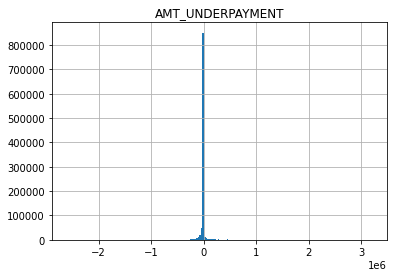

In [36]:
payments_v_installment[['AMT_UNDERPAYMENT']].to_pandas().hist(bins=200)

In [37]:
payments_v_installment[['AMT_UNDERPAYMENT']].mean()

AMT_UNDERPAYMENT    2519.347326
dtype: float64

In [38]:
# why do people pay more than necessary?
payments_v_installment[['AMT_UNDERPAYMENT']].max()

AMT_UNDERPAYMENT    3195000.0
dtype: float64

In [39]:
payments_v_installment[payments_v_installment.AMT_UNDERPAYMENT>0].head()

,AMT_INSTALMENT,AMT_PAYMENT,AMT_UNDERPAYMENT
SK_ID_PREV,,,
2566832,128389.320,218389.320,90000.000
1220007,295700.265,530175.780,234475.515
1136443,214243.740,231213.645,16969.905
1168917,117766.350,133432.020,15665.670
2497778,384400.845,479057.670,94656.825


In [40]:
payments[payments.SK_ID_PREV==2309583].sort_values('NUM_INSTALMENT_VERSION')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
11145330,2309583,335116,1.0,1,-300.0,-327.0,4125.330,9000.000
11145329,2309583,335116,2.0,1,-300.0,-327.0,4874.670,9000.000
10361297,2309583,335116,3.0,2,-270.0,-296.0,3100.500,11250.000
10361298,2309583,335116,4.0,2,-270.0,-296.0,8149.500,11250.000
8197769,2309583,335116,6.0,3,-240.0,-261.0,3807.765,3807.765


For the above case what I suspect is happening is that the customer has 6 installments. (NUM_INSTASLMENT_VERSION)
They paid it off in three payments (NUM_INSTALMENT_NUMBER). The computer is probably recording the AMT_PAYMENT wrong as for INSTALMENT_VERSION 1.0/2.0 the AMT_INSTALMENT sums to 9000 which matches up with one of the AMT_PAYMENTS

In [42]:
# check another
# okay we can have the other way around where the first instalment was paid off in 4 days...
payments[payments.SK_ID_PREV==1681399].sort_values('NUM_INSTALMENT_VERSION').sort_values('DAYS_INSTALMENT')


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1559540,1681399,171782,1.0,1,-713.0,-723.0,6843.555,6843.555
1039176,1681399,171782,1.0,2,-683.0,-698.0,6843.555,6843.555
511738,1681399,171782,1.0,3,-653.0,-670.0,6843.555,6843.555
1645212,1681399,171782,1.0,4,-623.0,-639.0,6843.555,11709.450
1645213,1681399,171782,2.0,4,-623.0,-639.0,4865.895,11709.450
2951701,1681399,171782,3.0,5,-593.0,-606.0,5923.890,5923.890
881169,1681399,171782,3.0,6,-563.0,-580.0,5923.890,5923.890
1427038,1681399,171782,4.0,7,-533.0,-550.0,22456.620,22456.620


In [43]:
# Negative means that we paid less than required
payments_v_installment[['AMT_UNDERPAYMENT']].min()

AMT_UNDERPAYMENT   -2602348.965
dtype: float64

In [44]:
payments[payments['AMT_PAYMENT']>0][['SK_ID_PREV', 'AMT_INSTALMENT', 'AMT_PAYMENT']]

,SK_ID_PREV,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,6948.360,6948.360
1,1330831,1716.525,1716.525
2,2085231,25425.000,25425.000
3,2452527,24350.130,24350.130
4,2714724,2165.040,2160.585
...,...,...,...
13605344,2006721,2934.225,2934.225
13605345,1126000,6793.470,6750.000
13605346,1519070,4363.830,4363.830
13605347,2784672,373.005,373.005


#### Attempt to fix up the AMTs in the installment payment data

In [45]:
# lets just check hypothesis once more...
# split into payments and instalments
# with days late of early

In [46]:
due_instalments = payments[['SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'DAYS_INSTALMENT', 'AMT_INSTALMENT']].drop_duplicates()
instalment_payments = payments[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER', 'DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']].drop_duplicates()

In [47]:
Total_AMT = due_instalments[['SK_ID_PREV', 'AMT_INSTALMENT']].groupby('SK_ID_PREV').agg('sum')

In [48]:
Total_Payments = instalment_payments[['SK_ID_PREV', 'AMT_PAYMENT']].groupby('SK_ID_PREV').agg('sum')

In [49]:
prev_loan_payments = Total_AMT.join(Total_Payments)
prev_loan_payments['AMT_UNDERPAYMENT'] = prev_loan_payments['AMT_PAYMENT'] - prev_loan_payments['AMT_INSTALMENT'] 

In [50]:
prev_loan_payments.head(10)

,AMT_INSTALMENT,AMT_PAYMENT,AMT_UNDERPAYMENT
SK_ID_PREV,,,
2198508,501814.800,501814.800,5.820766e-11
1412244,175981.140,175981.140,0.000000e+00
2022458,190857.960,190857.960,-2.910383e-11
1721039,92958.930,92958.930,1.455192e-11
1386444,948753.720,948753.720,0.000000e+00
1884899,119269.980,119269.980,0.000000e+00
2247428,642824.730,642824.730,0.000000e+00
2270515,54168.525,54168.525,0.000000e+00
1916031,84955.815,84955.815,-1.455192e-11


In [51]:
# this is a bit weird....
prev_loan_payments[prev_loan_payments['AMT_UNDERPAYMENT'] >= 100000]

,AMT_INSTALMENT,AMT_PAYMENT,AMT_UNDERPAYMENT
SK_ID_PREV,,,
2239408,0.00,150239.430,150239.430
1877030,526902.57,2546344.215,2019441.645
2311125,0.00,2483614.170,2483614.170
1686655,130500.00,261000.000,130500.000
1922028,211500.00,423000.000,211500.000
2060229,0.00,818842.500,818842.500
1994625,211500.00,423000.000,211500.000
1822101,0.00,137053.710,137053.710
1739888,270000.00,540000.000,270000.000


In [52]:
# this one is really weird... 
payments[payments['SK_ID_PREV']==2239408].sort_values('DAYS_INSTALMENT') 

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8756567,2239408,373540,1.0,1,-2293.0,-2316.0,0.0,12531.465
9263493,2239408,373540,1.0,2,-2263.0,-2287.0,0.0,12531.465
11079092,2239408,373540,1.0,3,-2233.0,-2255.0,0.0,12531.465
9740239,2239408,373540,1.0,4,-2203.0,-2220.0,0.0,12531.465
8637498,2239408,373540,1.0,5,-2173.0,-2197.0,0.0,12531.465
7731343,2239408,373540,1.0,6,-2143.0,-2162.0,0.0,12531.465
9122464,2239408,373540,1.0,7,-2113.0,-2127.0,0.0,12531.465
11094751,2239408,373540,1.0,8,-2083.0,-2091.0,0.0,12531.465
9587743,2239408,373540,1.0,9,-2053.0,-2066.0,0.0,12531.465
9255530,2239408,373540,1.0,10,-2023.0,-2036.0,0.0,12531.465


In [53]:
# lets grab last three loans for each person by instalment
closest_pay = payments[['SK_ID_PREV', 'DAYS_INSTALMENT']].groupby('SK_ID_PREV').agg('max')
closest_pay.isna().any() # we have no NAs

# not sure why the join isn't working yet
payments_tt = payments[['SK_ID_CURR', 'SK_ID_PREV']].drop_duplicates()
payments_tt.head(10)
#.join(closest_pay, on='SK_ID_PREV')

,SK_ID_CURR,SK_ID_PREV
1478621,100001,1369693
1761012,100001,1851984
185679,100002,1038818
13709,100003,1810518
480811,100003,2396755
1233145,100003,2636178
1263941,100004,1564014
477244,100005,2495675
681160,100006,2078043
100902,100006,2190416


## POS Cash Balance

In [54]:
pc_balance = xd.read_csv('data/POS_CASH_balance.csv')

In [55]:
pc_balance.shape

(10001358, 8)

In [56]:
pc_balance.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [57]:
pc_balance.dtypes

SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

In [58]:
pc_balance.NAME_CONTRACT_STATUS.unique()

0                   Active
1           Amortized debt
2                 Approved
3                 Canceled
4                Completed
5                   Demand
6    Returned to the store
7                   Signed
8                      XNA
Name: NAME_CONTRACT_STATUS, dtype: object

### Some Checks and Hypothesises

Lets check if POS CASH / Instalments and Credit Card Balance are independent different types of prev balance. We need to run this rapids check because numpy can't accept the cudf series as input. There exists a cupy which is a gpu replacement for numpy cupy doesn't implement `intersect1d` yet

In [59]:
if RAPIDS:
    cc_bal_id = cc_balance.SK_ID_PREV.to_pandas()
    payments_id = payments.SK_ID_PREV.to_pandas()
    pc_bal_id = pc_balance.SK_ID_PREV.to_pandas()
else:
    cc_bal_id = cc_balance.SK_ID_PREV
    payments_id = payments.SK_ID_PREV
    pc_bal_id = pc_balance.SK_ID_PREV

In [60]:
len(np.intersect1d(pc_bal_id, payments_id))

924949

In [61]:
len(np.intersect1d(cc_bal_id, payments_id))

72466

In [62]:
len(np.intersect1d(cc_bal_id, pc_bal_id))

0

okay so the IDs do overlap...

### Previous Loan Applications

previous loans can be very indicative of what the customer will do with current loans

In [64]:
pandas_dtypes = {'NAME_CONTRACT_TYPE': 'category', 'WEEKDAY_APPR_PROCESS_START': 'category',
                 'FLAG_LAST_APPL_PER_CONTRACT': 'category', 
                 'NAME_CONTRACT_STATUS': 'category',
                 'NAME_SELLER_INDUSTRY': 'category', 'NAME_YIELD_GROUP': 'category'}

if RAPIDS: 
    prev_dtypes = [] # rapids doesn't accept partial dtypes
else: 
    prev_dtypes = pandas_dtypes 
    
    
prev = xd.read_csv('data/previous_application.csv',
                  dtype=prev_dtypes)

In [65]:
prev.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [66]:
prev.dtypes

SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

In [67]:
prev[['DAYS_LAST_DUE', 'DAYS_TERMINATION']].head()

,DAYS_LAST_DUE,DAYS_TERMINATION
0,-42.0,-37.0
1,365243.0,365243.0
2,365243.0,365243.0
3,-182.0,-177.0
4,<NA>,<NA>


In [68]:
prev.PRODUCT_COMBINATION.unique()

0                               <NA>
1                        Card Street
2                        Card X-Sell
3                               Cash
4                  Cash Street: high
5                   Cash Street: low
6                Cash Street: middle
7                  Cash X-Sell: high
8                   Cash X-Sell: low
9                Cash X-Sell: middle
10       POS household with interest
11    POS household without interest
12        POS industry with interest
13     POS industry without interest
14          POS mobile with interest
15       POS mobile without interest
16           POS other with interest
17       POS others without interest
Name: PRODUCT_COMBINATION, dtype: object

In [69]:
prev.shape

(1670214, 37)

In [70]:
len(prev.SK_ID_PREV.unique())

1670214

SK_ID_PREV is the primary key.

Lets explore the previous loan history of applicants

In [71]:
# interesting features to consider:
prev.CODE_REJECT_REASON.unique()

0    CLIENT
1        HC
2     LIMIT
3       SCO
4     SCOFR
5    SYSTEM
6     VERIF
7       XAP
8       XNA
Name: CODE_REJECT_REASON, dtype: object

In [72]:
prev[['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON']] \
    .sort_values('SK_ID_CURR').head(10)

,SK_ID_CURR,SK_ID_PREV,NAME_CONTRACT_STATUS,CODE_REJECT_REASON
201668,100001,1369693,Approved,XAP
892077,100002,1038818,Approved,XAP
575941,100003,1810518,Approved,XAP
1021650,100003,2636178,Approved,XAP
1223745,100003,2396755,Approved,XAP
935548,100004,1564014,Approved,XAP
1259112,100005,1857999,Canceled,XAP
1378978,100005,2495675,Approved,XAP
98162,100006,2078043,Approved,XAP
617859,100006,2827850,Canceled,XAP


We can use the `NAME_CONTRACT_STATUS` column to check previous loan approval or reject
We need to see if we can check if these loans were paid off

### Loan Applications that we are testing

In [74]:
pandas_dtypes = {'NAME_CONTRACT_TYPE': 'category', 'CODE_GENDER': 'category',
                          'NAME_TYPE_SUITE': 'category', 'NAME_INCOME_TYPE': 'category',
                          'NAME_EDUCATION_TYPE': 'category', 'NAME_FAMILY_STATUS': 'category',
                          'NAME_HOUSING_TYPE': 'category', 'FLAG_MOBIL': 'bool', 
                          'FLAG_EMP_PHONE': 'bool', 'FLAG_WORK_PHONE': 'bool',
                          'FLAG_CONT_MOBILE': 'bool', 'FLAG_PHONE': 'bool', 
                  'FLAG_EMAIL': 'bool',
                          'OCCUPATION_TYPE': 'category', 'CNT_FAM_MEMBERS': 'Int64', 'REGION_RATING_CLIENT': 'category',
                          'REGION_RATING_CLIENT_W_CITY': 'category', 'WEEKDAY_APPR_PROCESS_START': 'category',
                          'HOUR_APPR_PROCESS_START': 'category', 'REG_REGION_NOT_LIVE_REGION': 'bool',
                          'REG_REGION_NOT_WORK_REGION': 'bool', 'LIVE_REGION_NOT_WORK_REGION': 'bool',
                          'REG_CITY_NOT_LIVE_CITY': 'bool', 'REG_CITY_NOT_WORK_CITY': 'bool',
                          'LIVE_CITY_NOT_WORK_CITY': 'bool', 'ORGANIZATION_TYPE': 'category',
                          'OBS_30_CNT_SOCIAL_CIRCLE': 'Int64', 'DEF_30_CNT_SOCIAL_CIRCLE': 'Int64',
                          'OBS_60_CNT_SOCIAL_CIRCLE': 'Int64', 'DEF_60_CNT_SOCIAL_CIRCLE': 'Int64',
                          'DAYS_LAST_PHONE_CHANGE': 'Int64', 'FLAG_DOCUMENT_2': 'bool',
                          'FLAG_DOCUMENT_3': 'bool', 'FLAG_DOCUMENT_4': 'bool', 'FLAG_DOCUMENT_5': 'bool',
                          'FLAG_DOCUMENT_6': 'bool', 'FLAG_DOCUMENT_7': 'bool', 'FLAG_DOCUMENT_8': 'bool',
                          'FLAG_DOCUMENT_9': 'bool', 'FLAG_DOCUMENT_10': 'bool', 'FLAG_DOCUMENT_11': 'bool',
                          'FLAG_DOCUMENT_12': 'bool', 'FLAG_DOCUMENT_13': 'bool', 'FLAG_DOCUMENT_14': 'bool', 
                          'FLAG_DOCUMENT_15': 'bool', 'FLAG_DOCUMENT_16': 'bool', 'FLAG_DOCUMENT_17': 'bool',
                          'FLAG_DOCUMENT_18': 'bool', 'FLAG_DOCUMENT_19': 'bool', 'FLAG_DOCUMENT_20': 'bool',
                          'FLAG_DOCUMENT_21': 'bool', 'AMT_REQ_CREDIT_BUREAU_HOUR': 'Int64',
                          'AMT_REQ_CREDIT_BUREAU_DAY': 'Int64', 'AMT_REQ_CREDIT_BUREAU_WEEK': 'Int64',
                          'AMT_REQ_CREDIT_BUREAU_MON': 'Int64', 'AMT_REQ_CREDIT_BUREAU_QRT': 'Int64',
                          'AMT_REQ_CREDIT_BUREAU_YEAR': 'Int64'}

if RAPIDS: 
    traintest_dtypes = [] # rapids doesn't accept partial dtypes
else: 
    traintest_dtypes = pandas_dtypes 

train = xd.read_csv('data/application_train.csv',
                    index_col='SK_ID_CURR',
                    dtype=traintest_dtypes)
test = xd.read_csv('data/application_test.csv',
                    index_col='SK_ID_CURR',
                    dtype=traintest_dtypes)

In [75]:
### Bool Conversions
train.FLAG_OWN_CAR = train.FLAG_OWN_CAR.eq('Y').mul(1).astype('bool')
train.FLAG_OWN_REALTY = train.FLAG_OWN_REALTY.eq('Y').mul(1).astype('bool')
test.FLAG_OWN_CAR = test.FLAG_OWN_CAR.eq('Y').mul(1).astype('bool')
test.FLAG_OWN_REALTY = test.FLAG_OWN_REALTY.eq('Y').mul(1).astype('bool')

In [76]:
train.shape

(307511, 121)

In [81]:
list(train.columns)

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BU

In [78]:
train.dtypes

TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                     bool
FLAG_OWN_REALTY                  bool
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object

In [82]:
train[['TARGET', 'NAME_CONTRACT_TYPE']].groupby('TARGET').count()

,NAME_CONTRACT_TYPE
TARGET,
0,282686
1,24825


In [83]:
train.FLAG_DOCUMENT_2.unique()

0    0
1    1
Name: FLAG_DOCUMENT_2, dtype: int64

In [84]:
train.DAYS_LAST_PHONE_CHANGE.isnull().unique()

0    False
1     True
Name: DAYS_LAST_PHONE_CHANGE, dtype: bool